# Mediods Analysis

This experiment has the purpose of analysing the medoid of some of the clusters defined in the previous experiment. According to it, the best number of cluster is ?? regarding the square of the 2-norm distance, ?? regarding the silhoutte score and ?? regarding the davies-bouldin score. Therefore, the number of clusters that we will use in the present experiment is ??.


In [53]:
import sys
import os
sys.path.append('../')
from src import reader as r
from src import visualization as v

In [46]:
%matplotlib notebook
import numpy as np
import pandas as pd
import sklearn
print(sklearn.__version__)
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import pairwise_distances

0.20.0


In [47]:
X = r.readBOW()
npX = X.values
print(npX)
print(X.head(10))
print(X.shape)

['health.txt', 'bags.csv', 'word2vec.csv']
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.55220061 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
     0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9   ...    0.1185  0.1186  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   ...       0.0     0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   ...       0.0     0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   ...       0.0     0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   ...       0.0     0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   ...       0.0     0.0   
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

In [48]:
news = r.readNews()
print(news.head(10))
# Tem uma coisa muito estranha nos dados.
# A variável news contem 13229 linhas, enquanto
# as features só possuem 13228 linhas. Pq isso?
# Precisamos investigar.
news = news.iloc[:-1,]

['health.txt', 'bags.csv', 'word2vec.csv']
                   id                    publish_date  \
0  576880531301801984  Sat Mar 14 23:00:11 +0000 2015   
1  576820122666471424  Sat Mar 14 19:00:08 +0000 2015   
2  576744652717461504  Sat Mar 14 14:00:15 +0000 2015   
3  576736754436304896  Sat Mar 14 13:28:52 +0000 2015   
4  576736614766010368  Sat Mar 14 13:28:18 +0000 2015   
5  576548368740052992  Sat Mar 14 01:00:17 +0000 2015   
6  576518190286536704  Fri Mar 13 23:00:22 +0000 2015   
7  576494177971732480  Fri Mar 13 21:24:57 +0000 2015   
8  576472874946433024  Fri Mar 13 20:00:18 +0000 2015   
9  576464606551490560  Fri Mar 13 19:27:27 +0000 2015   

                                       headline_test  
0  An abundance of online info can turn us into e...  
1  A plant-based diet that incorporates fish may ...  
2  It doesn't take much to damage your hearing at...  
3  RT @CNN: Forever young? Discover this island’s...  
4  RT @CNN: Is post-traumatic stress disorder in ...  

In [5]:
from MulticoreTSNE import MulticoreTSNE as TSNE

smp_sz = X.size
tsne_bow = TSNE(n_components=2, perplexity=10, verbose=True, n_jobs=-1)#500
tsne_bow_result = tsne_bow.fit_transform(X)

## Computing the Medoids
In here, we compute the medoids as the closest point to the centroids of the clusters.

In [74]:
best_K = 72
print("#############################")
print("Best K =", best_K)
print("Applying K-means")
best_cluster = KMeans(n_clusters=best_K, n_jobs=-1)
best_cluster_result = best_cluster.fit(X)
print("Finished")
print("#############################")    

#############################
Best K = 72
Applying K-means
Finished
#############################


In [7]:
y_pred = best_cluster_result.labels_
arrays=[]
for i in range(best_K):
    dist = np.linalg.norm(best_cluster_result.cluster_centers_[i]-npX[y_pred==i],axis=1)
    index = np.argmin(dist)
    arrays.append(npX[y_pred==i][index])   

medoids = np.vstack(arrays)
print(medoids.shape)
print(medoids)

(62, 1203)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [8]:
l = []
for i in range(best_K):
    l.append(np.where(np.all(npX==medoids[i],axis=1))[0][0]) # these last [0][0] return the index, since the output of this command is (array([id]),)
    
medoids_index = np.array(l)
print(medoids_index)
print(len(np.unique(medoids_index)))

[  474  2943    98  6774  4129  6851  2322  3585  6448  5921  6062  5868
  2922   953  4896 11768  3871  2784  7662  8890  6210  9778 10132  2298
  3690  1585  3884  5019  9110 11016  3356  9419  2632  4286  9323  5437
 10092 12112  6088  4386   568  9598  9355  2462  2189  4565  7688  9907
  1722  5852  2970  3811 12880  4554  7290  4613  1932   890  6073  2797
  5066  6180]
62


## Selecting medoids neighbors
Here the medoids neighbors are selected in order to plot them and see if the clusters make sense.

In [75]:
nm = 5 #number of medoids to be analyzed
nn = 5 #number of neighbor of each medoids
np.random.seed(42)
selected_medoids_index = np.random.randint(0,61,nm)
selected_medoids = medoids[selected_medoids_index]
print("Random indexes:",selected_medoids_index)
indexes_per_medoid = []

for i in range(nm):
    p = selected_medoids[i]
    aux = npX[y_pred==selected_medoids_index[i]]
    d = np.linalg.norm(aux-p,axis=1)
    points = []
    points.append(index[selected_medoids_index[i]])
    
    for j in range(nnp):
        min_d = d.argmin()
        while (d[min_d] == 0.):
            d[min_d] = np.inf
            min_d = d.argmin()
        points = points + (np.where(np.all(npX==aux[min_d],axis=1))[0]).tolist()
        d[min_d] = np.inf
        
    print(len(np.unique(points).tolist()))
    indexes_per_medoid.append(np.unique(points).tolist())

    
print("Points:",indexes_per_medoid)
print(len(indexes_per_medoid))

Random indexes: [38 51 28 14 42]
42
6
6
7
6
Points: [[6088, 6232, 6294, 6344, 6394, 6443, 6499, 6664, 6730, 6797, 6945, 6997, 7048, 7105, 7246, 7308, 7436, 7545, 7595, 7646, 7701, 7752, 7807, 7948, 8013, 8063, 8114, 8178, 8311, 8371, 8435, 8484, 8533, 8582, 8638, 8873, 8936, 8999, 9070, 9157, 9207, 9269], [485, 1864, 3811, 9403, 9690, 11746], [466, 2716, 6702, 8289, 9110, 9111], [4896, 4947, 9753, 10534, 10536, 10576, 10988], [4205, 4365, 5797, 9355, 9499, 10124]]
5


### Exporting medoids and clusters news

In [79]:
print("Random indexes:",selected_medoids_index)
for i in range(best_K):
    np.savetxt("../output/clusters/k_"+str(i)+".txt", news[y_pred==i].values, fmt='%s')
for i in range(selected_medoids_index.size):
    p = indexes_per_medoid[i]
    np.savetxt("../output/medoids/k_"+str(selected_medoids_index[i])+".txt", np.take(news,p,0).values, fmt='%s')

Random indexes: [38 51 28 14 42]


### News of the medoids and their neighbors

In [77]:
for p in indexes_per_medoid:
    info = np.take(news,p,0).loc[:,"headline_test"].values
    print("----------------------------")
    for i in range(info.size):
        print(info[i],"\n")
print("----------------------------")

----------------------------
6 foods that can change your life: 

How much sleep you really need tonight, and what can happen if you don't get it: 

The 10 worst cities for spring allergies: 

Male-pattern baldness, swelling, and other not-so-obvious physical signs of heart disease: 

Need another reason to quit smoking? Doing so can half your risk of oral health problems: 

Prepare for the late-night munchies with these tips to fend off cravings: 

#AtrialFibrillation Increases Risk of Kidney Failure 

10 foods that boost your skin &amp; slim your waistline: 

Hungover? Too tired? Your top exercise excuses -- busted: 

When people who have never smoked get lung cancer: 

Allergies got you bad? Sinus-clearing foods to eat this spring: 

More Americans are doing it -- and doing it safely: 

Canned foods, bicycles, and more surprising habits that are hurting his sex life: 

Toss the pop, and try these 10 soda alternatives instead! 

Diabetes Drug Adherence Linked to Doctor Communication 

### News of the medoids and their neighbors (Plot)

<IPython.core.display.Javascript object>


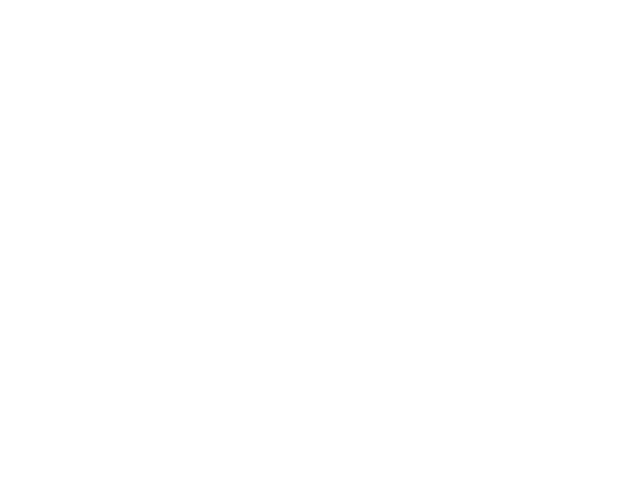

In [78]:
true_label = np.zeros((npX.shape[0],1))
np.put(true_label,index,1)
info = np.take(news,indexes_per_medoid[4],0).loc[:,"headline_test"]

plot = v.visualize_sup_scatter_hover(tsne_bow_result[points], true_label[points], info.values)
plot.show()